In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google import colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/FYP

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/FYP


## Importing Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib as nlp
tweets=pd.read_csv('cyberbullying_tweets.csv')
tweets

,TWEET_TEXT,CYBERBULLYING_TYPE,AGE,GENDER,RELIGION,ETHNICITY,OTHER,RESULT
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,0,0,0,0,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,0,0,0,0,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,0,0,0,0,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,0,0,0,0,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,0,0,0,1,0,1
47688,Turner did not withhold his disappointment. Tu...,ethnicity,0,0,0,1,0,1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,0,0,0,1,0,1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,0,0,0,1,0,1


In [4]:
print("Dataset shape:", tweets.shape)

Dataset shape: (47692, 8)


In [6]:
tweets['RESULT'].unique()

array([0, 1])

## Step 1 : Currently 0=Positive,1=Negative
### So that we can understand the data

## Removing the unnecessary columns.

In [12]:
tweets.columns
#tweets.drop(['CYBERBULLYING_TYPE','AGE','GENDER','RELIGION', 'ETHNICITY', 'OTHER'], inplace=True)
tweets.head(10)

,TWEET_TEXT,RESULT
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",0
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,0
7,Karma. I hope it bites Kat on the butt. She is...,0
8,@stockputout everything but mostly my priest,0
9,Rebecca Black Drops Out of School Due to Bully...,0


## Checking if any null values present

In [13]:
(tweets.isnull().sum() / len(tweets))*100

TWEET_TEXT    0.0
RESULT        0.0
dtype: float64

In [14]:
#converting pandas object to a string type
tweets['TWEET_TEXT'] = tweets['TWEET_TEXT'].astype('str')

## Check the number of positive vs. negative tagged sentences

In [15]:
positives = tweets['RESULT'][tweets.RESULT == 0 ]
negatives = tweets['RESULT'][tweets.RESULT == 1 ]

print('Total length of the data is:         {}'.format(tweets.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         47692
No. of positve tagged sentences is:  7945
No. of negative tagged sentences is: 39747


In [16]:
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) 
#that a search engine has been programmed to ignore,
#both when indexing entries for searching and when retrieving them as the result of a search query.
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'other', 'am', 'by', 'should', 'all', 'ourselves', 'me', 'below', 'very', 'to', 'and', 'such', 'a', 'why', 'yours', 'needn', 'o', 'your', 'yourself', 'an', 'here', 'itself', "it's", 'while', 'between', "aren't", 'of', 'during', 'didn', 'with', 'shouldn', 'after', 'most', 'off', "doesn't", 'than', 'down', 't', 'no', 'some', 'as', 'when', 'only', 'about', 'then', 'or', 'weren', 'is', 'ain', 'more', 'been', 'shan', 'those', 'into', 'has', "hadn't", 'd', "you're", 'what', "wouldn't", 'himself', 're', 'before', 'up', 'are', 'under', 'who', 'm', 'it', "hasn't", 'for', 'how', 'yourselves', 'where', 'can', 'they', "she's", 'herself', 'couldn', 'do', 'theirs', 'until', 'did', "isn't", "mightn't", 'again', 'mightn', 'not', "weren't", 'myself', 'have', 'haven', 'hasn', "didn't", 'over', "don't", 'we', 'there', 'him', 'on', "you'll", "wasn't", 'hers', 'this', 'these', "couldn't", 'isn', 

## Data Cleaning

In [17]:
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
some = 'amp,today,tomorrow,going,girl'
def process_tweets(tweet):
  # Lower Casing
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #remove some words
    tweet= re.sub(some,'',tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #tokens = [w for w in tokens if len(w)>2]
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [18]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [19]:
def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t)  

## Text Processing Completed

In [23]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [24]:
tweets['processed_tweets'] = tweets['TWEET_TEXT'].apply(lambda x: process_tweets(x))
tweets['processed_tweets'] = tweets['processed_tweets'].apply(lambda x: convert_abbrev_in_text(x))
print('Text Preprocessing complete.')
tweets

Text Preprocessing complete.


,TWEET_TEXT,RESULT,processed_tweets
0,"In other words #katandandre, your food was cra...",0,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,hy aussietv white mkr theblock imacelebrityau ...
2,@XochitlSuckkks a classy whore? Or more red ve...,0,xochitlsuckkks classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,jasongio meh thanks head concerned another ang...
4,@RudhoeEnglish This is an ISIS account pretend...,0,rudhoeenglish isi account pretending kurdish a...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",1,lack people expected anything depended anythin...
47688,Turner did not withhold his disappointment. Tu...,1,urner withhold disappointment turner called co...
47689,I swear to God. This dumb nigger bitch. I have...,1,swear god dumb nigger bitch got bleach hair re...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,1,ea fuck retweet youre nigger fucking unfollow ...


In [25]:
#removing shortwords
tweets['processed_tweets']=tweets['processed_tweets'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
tweets.head(5)

,TWEET_TEXT,RESULT,processed_tweets
0,"In other words #katandandre, your food was cra...",0,word katandandre food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,aussietv white theblock imacelebrityau today s...
2,@XochitlSuckkks a classy whore? Or more red ve...,0,xochitlsuckkks classy whore velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,jasongio thanks head concerned another angry d...
4,@RudhoeEnglish This is an ISIS account pretend...,0,rudhoeenglish account pretending kurdish accou...


In [26]:
from sklearn.utils import shuffle
tweets =  shuffle(tweets).reset_index(drop=True)


## Tokenization

In [27]:
tokenized_tweet=tweets['processed_tweets'].apply(lambda x: x.split())
tokenized_tweet.head(5)

0    [iley, cyrus, make, rape, joke, onstage, ledia...
1    [someone, please, remind, difference, child, c...
2    [sibechukcha, bully, jeje, adalah, satu, kesen...
3    [literally, cant, anything, thts, praise, blac...
4    [pointproven, laughing, loud, retweet, hate, n...
Name: processed_tweets, dtype: object

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(tweets['processed_tweets'].values.astype('U'))

## Train/Test Split

In [30]:
from sklearn.model_selection import train_test_split
X=text_counts
y=tweets['RESULT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=19)


## Naive Bayes

In [31]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from math import *
cnb = ComplementNB()
cnb.fit(X_train, y_train)
cross_cnb = cross_val_score(cnb, X, y,n_jobs = -1)
print("Cross Validation score = ",cross_cnb)                
print ("Train accuracy ={:.2f}%".format(cnb.score(X_train,y_train)*100))
print ("Test accuracy ={:.2f}%".format(cnb.score(X_test,y_test)*100))
train_acc_cnb=cnb.score(X_train,y_train)
test_acc_cnb=cnb.score(X_test,y_test)

Cross Validation score =  [0.83530768 0.83205787 0.83350807 0.8280562  0.83780667]
Train accuracy =88.36%
Test accuracy =83.13%


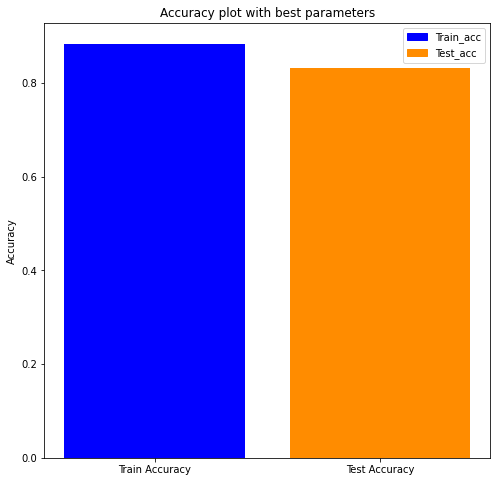

In [32]:
#plotting the best parameters
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
data_cnb = [train_acc_cnb,test_acc_cnb]
labels = ['Train Accuracy','Test Accuracy']
plt.xticks(range(len(data_cnb)), labels)
plt.ylabel('Accuracy')
plt.title('Accuracy plot with best parameters')
plt.bar(range(len(data_cnb)), data_cnb,color=['blue','darkorange']) 
Train_acc = mpatches.Patch(color='blue', label='Train_acc')
Test_acc = mpatches.Patch(color='darkorange', label='Test_acc')
plt.legend(handles=[Train_acc, Test_acc],loc='best')
plt.gcf().set_size_inches(8, 8)
plt.show()

## Confusion Matrix

In [33]:
 from sklearn.metrics import *
#Predict test data set
y_pred_cnb =cnb.predict(X_test)

#This is the confusion matrix :
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred_cnb))

[[ 898  706]
 [ 903 7032]]


In [34]:
#Checking performance our model with classification report
print(classification_report(y_test, y_pred_cnb))

#Checking performance our model with ROC Score
roc_score_cnb=roc_auc_score(y_test, y_pred_cnb)
print("Area Under the Curve = ",roc_score_cnb)

              precision    recall  f1-score   support

           0       0.50      0.56      0.53      1604
           1       0.91      0.89      0.90      7935

    accuracy                           0.83      9539
   macro avg       0.70      0.72      0.71      9539
weighted avg       0.84      0.83      0.84      9539

Area Under the Curve =  0.7230253760683357


## Calculating F1, prescision and recall scores

In [35]:
from sklearn.metrics import *

print("F1 score ={:.2f}%".format(f1_score(y_test, y_pred_cnb, average="macro")*100))
f1_cnb=f1_score(y_test, y_pred_cnb, average="macro")
print("Precision score ={:.2f}%".format(precision_score(y_test, y_pred_cnb, average="macro")*100))
precision_cnb=precision_score(y_test, y_pred_cnb, average="macro")
print("Recall score ={:.2f}%".format(recall_score(y_test, y_pred_cnb, average="macro")*100))  
recall_cnb=recall_score(y_test, y_pred_cnb, average="macro")

F1 score =71.24%
Precision score =70.37%
Recall score =72.30%


## Drawing the ROC curve

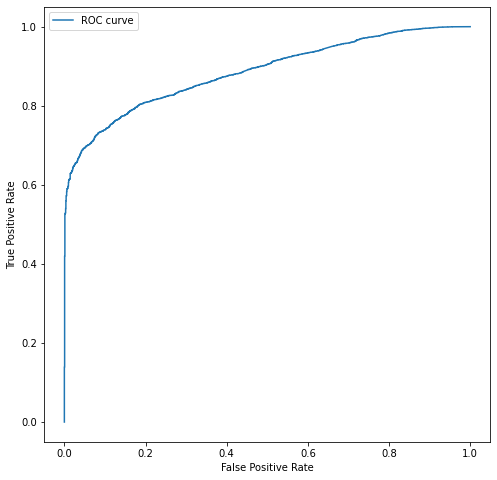

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
fpr_dt_1, tpr_dt_1,_=roc_curve(y_test,cnb.predict_proba(X_test)[:,1])
plt.plot(fpr_dt_1,tpr_dt_1,label="ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.gcf().set_size_inches(8, 8)
plt.show()